In [1]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn import tree
from sklearn import svm
from sklearn import neighbors
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, accuracy_score
from sklearn import metrics

from matplotlib import pyplot as plt
import plotly
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
import plotly.express as px

import seaborn as sns
import random

In [2]:
df_train_original = pd.read_csv(r"/content/fraudTrain.csv")

df_train_original.drop(df_train_original.columns[0], axis=1, inplace=True)

df_test_original = pd.read_csv(r"/content/fraudTest.csv")

df_test_original.drop(df_test_original.columns[0], axis=1, inplace=True)

# In order to seperate test and training subsets later on in the notebook
df_original = pd.concat([df_train_original,df_test_original], axis = 0)

In [6]:
# Define the proportion of the sample size we want
sample_size = 0.15

# Performing stratified sampling
# Drop rows with NaN in 'is_fraud' column before splitting
df_train_no_nan = df_train_original.dropna(subset=['is_fraud'])
df, _ = train_test_split(df_train_no_nan, test_size=1-sample_size, stratify=df_train_no_nan['is_fraud'], random_state=42)

# Displaying the sampled DataFrame
df.shape

(1172, 22)

**EDA**

In [7]:
def df_explore(df):
    missing = pd.DataFrame((df.isna().sum()/df.shape[0])*100).reset_index().rename(columns={'index': 'column',0:'%_missing'}).sort_values(by = '%_missing',ascending=False)
    nunique = pd.DataFrame(df.nunique()).reset_index().rename(columns={'index': 'column',0:'nunique'}).sort_values(by = 'nunique',ascending=False)
    dtypes = pd.DataFrame(df.dtypes).reset_index().rename(columns={'index': 'column',0:'dtype'})
    return pd.merge(pd.merge(dtypes,missing,on='column'),nunique,on='column',how='left').sort_values(by='%_missing',ascending=False).sort_values(by = 'nunique', ascending = False)
print(df.shape)

df_explore(df).head(10)

(1172, 22)


,column,dtype,%_missing,nunique
20,merch_long,float64,0.0,1172
19,merch_lat,float64,0.0,1172
17,trans_num,object,0.0,1172
0,trans_date_trans_time,object,0.0,1169
18,unix_time,float64,0.0,1169
4,amt,float64,0.0,1086
8,street,object,0.0,603
1,cc_num,int64,0.0,603
12,lat,float64,0.0,599
11,zip,float64,0.0,599


Data Balance Check

Text(0.5, 1.0, '% of Fraudulent vs Non-fraudulent transactions')

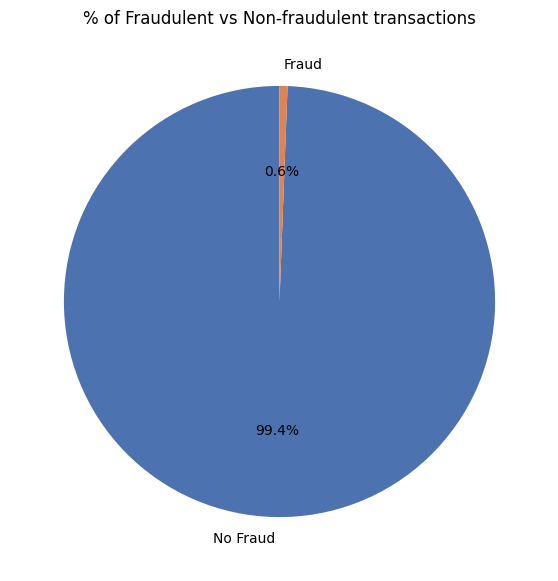

In [8]:
df['is_fraud_cat'] = df['is_fraud'].apply(lambda x: "Fraud" if x==1 else "No Fraud")

is_fraud_values = df['is_fraud_cat'].value_counts()

plt.figure(figsize=(7,7))
plt.pie(is_fraud_values, labels=is_fraud_values.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette("deep", n_colors=len(is_fraud_values)))
plt.title('% of Fraudulent vs Non-fraudulent transactions')

**Fraud by Transaction Category**

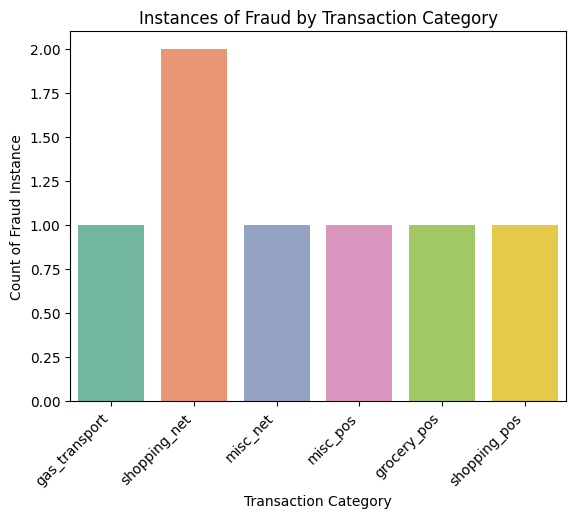

<Figure size 700x700 with 0 Axes>

In [9]:
sns.countplot(x="category", data=df[df['is_fraud_cat']=="Fraud"], palette="Set2", hue = 'category')

plt.title('Instances of Fraud by Transaction Category')
plt.xlabel('Transaction Category')
plt.ylabel('Count of Fraud Instance')
plt.xticks(rotation=45, ha = 'right')
plt.figure(figsize=(7, 7))
plt.show()

Fraud by Job

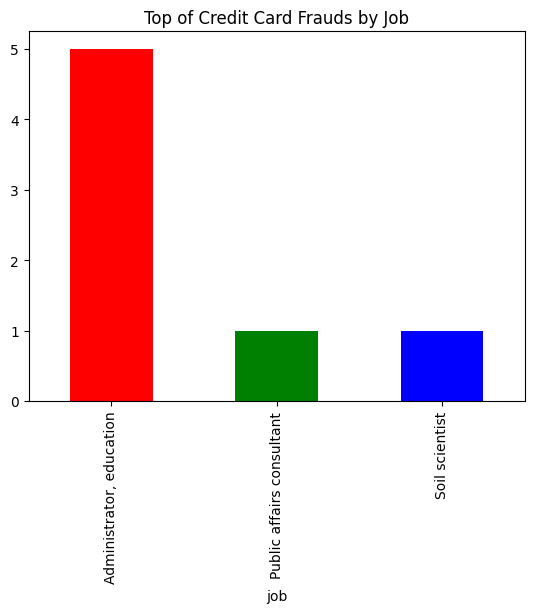

In [10]:
df[df['is_fraud_cat']=="Fraud"]["job"].value_counts(sort=True,ascending=False).head(10).plot(kind="bar",x='job', y=df['is_fraud_cat']=="Fraud", color=['red', 'green', 'blue', 'orange', 'purple'])
plt.title("Top of Credit Card Frauds by Job")
plt.show()

**Data Pre-processing**

In [11]:
df2 = df.copy()

df2.drop_duplicates(inplace=True)

print("Duplicated values dropped")

Duplicated values dropped


**Data Transformation**

In [12]:
def gender_transform(x):
    if x=='F':
        return 1
    if x=='M':
        return 0
df2['gender'] = df2['gender'].transform(gender_transform)

In [13]:
df3 = df2.drop(['unix_time','trans_date_trans_time','cc_num','trans_num','street','dob','city','merchant','job','last','first','state','is_fraud_cat'],axis = 1)

**Dummy Variables**


In [14]:
df3_dummies = pd.get_dummies(df3.select_dtypes('object'), dtype = int)

df4 = pd.concat([df3.drop(df3.select_dtypes('object').columns, axis = 1), df3_dummies],axis = 1)

print(df4.shape)
df4.head()

(1172, 23)


,amt,gender,zip,lat,long,city_pop,merch_lat,merch_long,is_fraud,category_entertainment,...,category_grocery_pos,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel
3182,76.64,0,82514.0,43.0048,-108.8964,1645.0,42.475287,-108.874086,0.0,0,...,0,1,0,0,0,0,0,0,0,0
4539,71.28,0,82711.0,44.6873,-104.4414,110.0,44.586464,-104.529921,0.0,0,...,0,0,1,0,0,0,0,0,0,0
4453,228.95,1,61830.0,39.9972,-88.6962,478.0,39.902292,-89.382233,0.0,1,...,0,0,0,0,0,0,0,0,0,0
5572,10.47,1,56592.0,47.5375,-95.9941,516.0,46.948318,-96.051877,0.0,0,...,0,0,0,0,0,0,0,0,0,0
3510,3.70,1,40820.0,36.7558,-83.1838,581.0,36.432098,-84.075522,0.0,0,...,0,0,0,1,0,0,0,0,0,0


**Stratified Train/Test split**

In [15]:
X = df4.reset_index(drop='index').drop('is_fraud', axis=1)

y = df4.reset_index(drop='index')['is_fraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.3, random_state = 42)

**4.4 Feature Scaling**

In [18]:
def Standard_Scaler (df, col_names):

    features = df[col_names]

    scaler = StandardScaler().fit(features.values)

    features = scaler.transform(features.values)

    df[col_names] = features

    return df

col_names = ['amt']

X_train = Standard_Scaler (X_train, col_names)

X_test = Standard_Scaler (X_test, col_names)

**Random Fores**

In [19]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=200)

In [20]:
rf.fit(X_train, y_train)
y_pred_baseline = rf.predict(X_test)

In [21]:
print("Performance with imbalanced dataset:")
print(classification_report(y_test, y_pred_baseline))

Performance with imbalanced dataset:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       350
         1.0       1.00      0.50      0.67         2

    accuracy                           1.00       352
   macro avg       1.00      0.75      0.83       352
weighted avg       1.00      1.00      1.00       352



In [22]:
cm = confusion_matrix(y_test, y_pred_baseline)

rf_baseline_Recall = recall_score(y_test, y_pred_baseline)
rf_baseline_Precision = precision_score(y_test, y_pred_baseline)
rf_baseline_f1 = f1_score(y_test, y_pred_baseline)
rf_baseline_accuracy = accuracy_score(y_test, y_pred_baseline)

ndf = [(rf_baseline_Recall, rf_baseline_Precision, rf_baseline_f1, rf_baseline_accuracy)]

rf_score = pd.DataFrame(data = ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
rf_score.insert(0, 'Random Forest performed with', 'Original (Imbalanced Dataset)')
rf_score

,Random Forest performed with,Recall,Precision,F1 Score,Accuracy
0,Original (Imbalanced Dataset),0.5,1.0,0.666667,0.997159


**Random Resampling Methods for Imbalanced Data**

In [23]:
from imblearn.over_sampling import RandomOverSampler
# defining oversampling method
ros = RandomOverSampler(random_state=42)

rf_oversample = RandomForestClassifier(n_estimators=200)
X_train_oversample, y_train_oversample = ros.fit_resample(X_train, y_train)


In [24]:
rf_oversample.fit(X_train_oversample, y_train_oversample)
y_pred_oversample = rf_oversample.predict(X_test)

In [25]:
print("Performance with Random Oversampling:")
print(classification_report(y_test, y_pred_oversample))

Performance with Random Oversampling:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       350
         1.0       1.00      0.50      0.67         2

    accuracy                           1.00       352
   macro avg       1.00      0.75      0.83       352
weighted avg       1.00      1.00      1.00       352



In [26]:
cm = confusion_matrix(y_test, y_pred_oversample)

oversample_rf_Recall = recall_score(y_test, y_pred_oversample)
oversample_rf_Precision = precision_score(y_test, y_pred_oversample)
oversample_rf_f1 = f1_score(y_test, y_pred_oversample)
oversample_rf_accuracy = accuracy_score(y_test, y_pred_oversample)

ndf_over = [(oversample_rf_Recall, oversample_rf_Precision, oversample_rf_f1, oversample_rf_accuracy)]

oversample_rf_score = pd.DataFrame(data = ndf_over, columns=['Recall','Precision','F1 Score', 'Accuracy'])
oversample_rf_score.insert(0, 'Random Forest performed with', 'Random Oversampling')
oversample_rf_score

,Random Forest performed with,Recall,Precision,F1 Score,Accuracy
0,Random Oversampling,0.5,1.0,0.666667,0.997159


**Random Undersampling**

In [27]:
from imblearn.under_sampling import RandomUnderSampler
# defining oversampling method
rus = RandomUnderSampler(random_state=42)

rf_undersample = RandomForestClassifier(n_estimators=200)
X_train_undersample, y_train_undersample = rus.fit_resample(X_train, y_train)

In [28]:
rf_undersample.fit(X_train_undersample, y_train_undersample)
y_pred_undersample = rf_undersample.predict(X_test)

In [29]:
print("Performance with Random Undersampling:")
print(classification_report(y_test, y_pred_undersample))

Performance with Random Undersampling:
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99       350
         1.0       0.14      0.50      0.22         2

    accuracy                           0.98       352
   macro avg       0.57      0.74      0.61       352
weighted avg       0.99      0.98      0.99       352



In [30]:
cm = confusion_matrix(y_test, y_pred_undersample)

undersample_rf_Recall = recall_score(y_test, y_pred_undersample)
undersample_rf_Precision = precision_score(y_test, y_pred_undersample)
undersample_rf_f1 = f1_score(y_test, y_pred_undersample)
undersample_rf_accuracy = accuracy_score(y_test, y_pred_undersample)

ndf_over = [(undersample_rf_Recall, undersample_rf_Precision, undersample_rf_f1, undersample_rf_accuracy)]

undersample_rf_score = pd.DataFrame(data = ndf_over, columns=['Recall','Precision','F1 Score', 'Accuracy'])
undersample_rf_score.insert(0, 'Random Forest performed with', 'Random Undersampling')
undersample_rf_score

,Random Forest performed with,Recall,Precision,F1 Score,Accuracy
0,Random Undersampling,0.5,0.142857,0.222222,0.980114


**SMOTE (Synthetic Minority Oversampling Technique)**

In [32]:
from imblearn.over_sampling import SMOTE

# Reducing the value of n_neighbors to 4 (or you can reduce it further if your minority has less than 5 samples)
smote = SMOTE(random_state=42, k_neighbors=4)
rf_smote = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [33]:
rf_smote.fit(X_train_smote,y_train_smote)
y_pred_smote = rf_smote.predict(X_test)

In [34]:
print("Performance with SMOTE:")
print(classification_report(y_test, y_pred_smote))

Performance with SMOTE:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       350
         1.0       1.00      0.50      0.67         2

    accuracy                           1.00       352
   macro avg       1.00      0.75      0.83       352
weighted avg       1.00      1.00      1.00       352



In [35]:
cm_smote = confusion_matrix(y_test, y_pred_smote)
rf_smote_Recall = recall_score(y_test, y_pred_smote)
rf_smote_Precision = precision_score(y_test, y_pred_smote)
rf_smote_f1 = f1_score(y_test, y_pred_smote)
rf_smote_accuracy = accuracy_score(y_test, y_pred_smote)

ndf = [(rf_smote_Recall, rf_smote_Precision, rf_smote_f1, rf_smote_accuracy)]

rf_smote_score = pd.DataFrame(data = ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
rf_smote_score.insert(0, 'Random Forest performed with', 'Smote Oversampling')
rf_smote_score

,Random Forest performed with,Recall,Precision,F1 Score,Accuracy
0,Smote Oversampling,0.5,1.0,0.666667,0.997159


In [37]:
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks

# Reducing k_neighbors to a value less than or equal to the minimum number of samples in any class
# Here, using 4 assuming the minimum number of samples in any class is 5.
# Change this to an appropriate value if the minimum number is less than 5.
SMOTETomek = SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'), smote=SMOTE(k_neighbors=4, random_state=42))
rf_SMOTETomek = RandomForestClassifier(n_estimators=200)
X_train_SMOTETomek, y_train_SMOTETomek = SMOTETomek.fit_resample(X_train, y_train)

**Fitting the Model**

In [38]:
rf_SMOTETomek.fit(X_train_SMOTETomek,y_train_SMOTETomek)
y_pred_SMOTETomek = rf_SMOTETomek.predict(X_test)

**Performance and Accuracy Scores**

In [39]:
print("Performance with SMOTE:")
print(classification_report(y_test, y_pred_SMOTETomek))

Performance with SMOTE:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       350
         1.0       1.00      0.50      0.67         2

    accuracy                           1.00       352
   macro avg       1.00      0.75      0.83       352
weighted avg       1.00      1.00      1.00       352



In [40]:
cm_smote_tomek = confusion_matrix(y_test, y_pred_SMOTETomek)
rf_smote_tomek_Recall = recall_score(y_test, y_pred_SMOTETomek)
rf_smote_tomek_Precision = precision_score(y_test, y_pred_SMOTETomek)
rf_smote_tomek_f1 = f1_score(y_test, y_pred_SMOTETomek)
rf_smote_tomek_accuracy = accuracy_score(y_test, y_pred_SMOTETomek)

ndf = [(rf_smote_tomek_Recall, rf_smote_tomek_Precision, rf_smote_tomek_f1, rf_smote_tomek_accuracy)]

rf_smote_tomek_score = pd.DataFrame(data = ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
rf_smote_tomek_score.insert(0, 'Random Forest performed with', 'SMOTE & Tomek')
rf_smote_tomek_score

,Random Forest performed with,Recall,Precision,F1 Score,Accuracy
0,SMOTE & Tomek,0.5,1.0,0.666667,0.997159


**Performance Summary**

In [41]:
rf_sampling_scores = pd.concat([rf_score, oversample_rf_score, undersample_rf_score,rf_smote_score, rf_smote_tomek_score],axis = 0)
rf_sampling_scores

,Random Forest performed with,Recall,Precision,F1 Score,Accuracy
0,Original (Imbalanced Dataset),0.5,1.000000,0.666667,0.997159
0,Random Oversampling,0.5,1.000000,0.666667,0.997159
0,Random Undersampling,0.5,0.142857,0.222222,0.980114
0,Smote Oversampling,0.5,1.000000,0.666667,0.997159
0,SMOTE & Tomek,0.5,1.000000,0.666667,0.997159


**Showing the accuracy score again**

In [42]:
accuracy = accuracy_score(y_test, y_pred_undersample)
print(f"Model Accuracy: {accuracy * 100:.2f}%")

Model Accuracy: 98.01%


**Print the predicted and actual class names**

In [44]:
# remapping the classes
class_names = {1:'Fraud',0:'No Fraud'}
predicted_classes = [class_names[label] for label in y_pred_undersample]

# Mapping true labels to custom class names
class_map = [class_names[label] for label in y_test]

# Step 10: Print the predicted and actual class names for the first 5 test samples
for i in range(20):
    print(f"Sample {i+1}: True Class: {class_map[i]}, Predicted Class: {predicted_classes[i]}")

Sample 1: True Class: No Fraud, Predicted Class: No Fraud
Sample 2: True Class: No Fraud, Predicted Class: No Fraud
Sample 3: True Class: No Fraud, Predicted Class: No Fraud
Sample 4: True Class: No Fraud, Predicted Class: No Fraud
Sample 5: True Class: No Fraud, Predicted Class: No Fraud
Sample 6: True Class: No Fraud, Predicted Class: No Fraud
Sample 7: True Class: No Fraud, Predicted Class: No Fraud
Sample 8: True Class: No Fraud, Predicted Class: Fraud
Sample 9: True Class: No Fraud, Predicted Class: No Fraud
Sample 10: True Class: No Fraud, Predicted Class: No Fraud
Sample 11: True Class: No Fraud, Predicted Class: No Fraud
Sample 12: True Class: No Fraud, Predicted Class: No Fraud
Sample 13: True Class: No Fraud, Predicted Class: No Fraud
Sample 14: True Class: No Fraud, Predicted Class: No Fraud
Sample 15: True Class: No Fraud, Predicted Class: No Fraud
Sample 16: True Class: No Fraud, Predicted Class: No Fraud
Sample 17: True Class: No Fraud, Predicted Class: No Fraud
Sample 18